# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

Проект 8: "Возьмете Bat-мобиль?"

Группа: DST-34

Выполнил: Макаров Сергей.

Цель работы: 

создать и обучить модель на основе классических методов машинного обучения и нейронных сетей (MLP - многослойный перцептрон, RNN - рекурентная нейронная сеть, CNN - сверточная нейронная сеть) для решения задачи регрессии по предсказанию цен на автомибили по объявлениям с сайта auto.ru. 

В качестве изображений выступают фото машин. 

В качестве текста - описания объявлений. 

В качестве табличных данных - параметры автомобилей. 

Парсинг данных не требуется. Метрика: 

MAPE - средняя относительная погрешность. 

Работа выполнялась на основе имеющегося Base-Line решения.

In [1]:
# Установим необходимые библиотеки
!pip install --upgrade pip
!pip install -q tensorflow==2.3
!pip install seaborn --upgrade
!pip install albumentations -q
!pip install pymystem3
!pip install nltk

     |████████████████████████████████| 1.6 MB 887 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2
     |████████████████████████████████| 292 kB 937 kB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hypertools 0.6.2 requires scikit-learn<0.22,>=0.19.1, but you have scikit-learn 0.23.2 which is incompatible.


In [61]:
# Загрузим необходимые пакеты

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import datetime
from string import punctuation

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression

from itertools import combinations
from scipy.stats import ttest_ind

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from pymystem3 import Mystem

import seaborn as sns
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Seaborn   :', sns.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Seaborn   : 0.11.2


In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

#для визулизаций
sns.set(style="darkgrid", font_scale=1.0)
sns.set_palette("pastel")

DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'

#Для NLP
snowball = SnowballStemmer(language="russian")
mystem = Mystem()
punctuation += '•«»–'
delete_english = re.compile("[а-яА-Я]+")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [5]:
!pip freeze > requirements.txt

## Вспомогательные функции

In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
class Visualizer():
    """
        Вход: график
        * data - DataFrame;
        * cols - столбцы в DataFrame;
        * size - размер графика.
        * x - признак в DataFrame по оси абсцисс;
        * y - целевой признак по оси ординат;
        * hue - дополнительное разделение по группам,
        * st - агрегирующая функция для вычисления порядка (mean, median и т.д.).
        Выход:
        * None."""
        
    def __get_order__(self, data,x,y,st):
        '''
        Функция для получения порядка значений категориального признака 
            по значению целевого признака (используется для box-plot).
        '''
        return data.groupby(x)[y].agg(st).sort_values().index
    
    def boxplot(self, data,x,y='log_price',size=(10,8),hue=None,st='mean',showmeans=True):
        #Box-Plot
        fig,axes = plt.subplots(1,1,figsize=size)
        order = self.__get_order__(data=data,x=x,y=y,st=st)
        boxplot = sns.boxplot(x=x,y=y,data=data,hue=hue,
                    order=self.__get_order__(data,x,y=y,st=st),
                    showmeans=showmeans,
                    meanprops={"marker":"o",
                               "markerfacecolor":"white",
                               "markeredgecolor":"black",
                               "markersize":"5"})
        pass

    def scterplot(self, data,x,y='log_price',hue=None):
        #Scatter-Plot
        sns.catplot(data=data,x=x,y=y,hue=hue)
        pass

    def histplot(self, data,x,y='log_price',hue=None, element='bars'):
        #Hist-Plot
        sns.histplot(data=data,x=x,y=y,hue=hue, stat='count', bins=25)
        pass

    def heatmap_corr(self, data, cols=None,size=(20,20)):
        #Plot
        fig, ax = plt.subplots(figsize = size)
        #Title
        ax.set_title('HeatMap for Correlation')
        if cols==None:
            cols=data.columns
        #Table of corr
        table_corr = data[cols].corr().round(2)
        #Plot-Seaborn
        sns.heatmap(table_corr, vmin=-1, vmax=1, cmap="YlGnBu",annot=True)
        #Show
        plt.yticks(rotation=0) 
        plt.show()
        pass
    
    def check_transf(self, data, col, func):
        #Место для Hist-Plot и его настройки
        fig, axes = plt.subplots(1,2,figsize = (10,5))
        #Название
        axes[0].set_title('До преобразования')
        axes[1].set_title('После преобразования')
            #Графики
            #Изначальный
        df_sub = data.copy()
        drop_init = check.Is_drop(df_sub,col,True)
        sns.histplot(x=col, data=df_sub, ax=axes[0], element='bars', bins=25)
            #Конечный
        df_sub[col] = df_sub[col].apply(func)
        drop_end = check.Is_drop(df_sub,col,True)
        sns.histplot(x=col, data=df_sub, ax=axes[1], element='bars', bins=25)
            #Вывод информации
        print('Признак {} преобразован. Количество выбросов до: {}; после {}; сокращено: {}.'.\
                 format(col,drop_init,drop_end,drop_init-drop_end))
            #Описание над графиком
        fig.suptitle('Hist-Plot for ' + col)
    
viz = Visualizer()

In [8]:
class check_data():
    """
    * df - DataFrame;
    * col - столбец в DataFrame
    * x - признак;
    * y - целевой признак;
    * show_lost_uniq - показать ли потерянные признаки в выборках?;
    * show_uniq - показать ли уникальные признаки?.
    """
    
    def Is_drop(self,df,col,return_count=False):
        '''
        Функция для определения выброс прецендент или нет (или выводы количества выбросов).
        '''
        #Квантили
        q25 = df[col].quantile(0.25)
        q75 = df[col].quantile(0.75)
        #Межквантильный размах
        IQR = q75 - q25
        #Выброс ли?
        df_sub = ~df[col].between(q25 - 1.5*IQR, q75 + 1.5*IQR)
        if return_count:
            return df_sub.sum()
        else:
            return df_sub
    
    def prn_info_feature(self,data,x,show_lost_uniq=True,show_uniq=False):
        '''
        Получение информации о признаке.
        '''
        #Количество уникальных значений
        nu = data[x].nunique()
        #Количество значений
        ln = len(data)
        #Количество пропусков
        na = data[x].isna().sum()
        #Уникальные значения
        uniq = list(data[x].unique())
        return nu,ln,na,uniq

    def get_corr(self,data,x,y='log_price'):
        '''
        Получение корреляции параметра с целевым.
        '''
        #Если передан один признак
        if type(x) != list:
            x = [x]
        return 100*data[x+[y]].corr().round(4)
    
    def Is_stat_dif(self,x,y,df,alpha=0.05):
        '''
        Поиск статически значимых параметров.
        '''
        #Список групп
        ind = df.loc[:, x].value_counts().index
        #Создание различных комбинаций из списка по 2
        combo = list(combinations(ind, 2))
        #Поиск
        for comb in combo:
            #Определение p-уровня значимости
            p = ttest_ind(df.loc[df.loc[:, x] == comb[0], y],
                         df.loc[df.loc[:, x] == comb[1], y]).pvalue
            #Проверка (знаменатель необходим для учета поправки Бонферрони)
            if p <= alpha / len(combo):
                print('Статистически значим: {}'.format(x))
                return [np.nan, x]
        else:
            print('Статистически не значим: {}'.format(x))
            return [x, np.nan]
        pass

check = check_data()

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
def data_load():
    """Функция загрузки данных"""
    train = pd.read_csv(DATA_DIR + 'train.csv')
    test = pd.read_csv(DATA_DIR + 'test.csv')
    
    # ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
    train['sample'] = 1 # помечаем где у нас трейн
    test['sample'] = 0 # помечаем где у нас тест
    test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

    data = test.append(train, sort=False).reset_index(drop=True) # объединяем
    
    return data

In [10]:
# Посмотрим на наши данные
data = data_load()
train = data.query("sample==1")
test = data.query("sample==0")
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 1671 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  productionDate        6682 non-null   int64  
 13  sell_id               6682 non-null   int64  
 14  vehicleConfiguration  6682 non-null   object 
 15  vehicleTransmissio

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
sample                     1
price                   1628
dtype: int64

In [12]:
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

In [13]:
# Проверим на ниличие пропусков и соберем данные для дальнейшего анализа
data_info = {}
for col in data.keys():
    nu,ln,na,uniq = check.prn_info_feature(data, col)
    data_info[col] = {'Nunique': nu
                     ,'Nvals': ln
                     ,'Nna': na
                     ,'Unique': data[col].value_counts()}
    if na>0: print('В поле {} всего {} значений, пропусков {}'.format(col,ln,na))

В поле Владельцы всего 8353 значений, пропусков 1
В поле Владение всего 8353 значений, пропусков 5418


In [ ]:
# Распределим все фичи по категориям
categorical_features = []
numerical_features = []
binary_features = []
drop_cols = []

In [ ]:
# Посмотрим на целевую переменную
col = 'price'
viz.check_transf(data[data['sample']==1], col, 'log')

In [ ]:
# Проводим преобразование и используем для предсказаний ее
data['log_price'] = data['price'].apply(lambda x: np.log(x+1))
drop_cols += ['price']

In [ ]:
# bodyType
col = 'bodyType'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price', (20,5))

In [ ]:
# Объединим типы по классам с похожим распределением
data['bodyType'].replace({'седан 2 дв.': 'седан', 'пикап двойная кабина':'лимузин',
                          'внедорожник открытый':'купе','внедорожник 3 дв.':'седан',
                          'компактвэн':'внедорожник открытый'}, inplace=True)
data['bodyType'].replace(['купе','открытый купе','лифтбек','кабриолет','родстер',
                          'внедорожник 5 дв.'],'другой', inplace=True)

categorical_features += ['bodyType']
viz.boxplot(data.query('sample==1'), col, 'log_price', (20,5))

In [ ]:
# brand
col = 'brand'
data_info[col]
viz.boxplot(data.query('sample==1'), col, 'log_price', (10,3))

In [ ]:
categorical_features += ['brand']

In [ ]:
# color
col = 'color'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price', (20,5))

In [ ]:
# Объединим категории с малым колличеством семплов
data[col].replace({
    'жёлтый':'другой',
    'розовый':'другой',
    'оранжевый':'другой'
}, inplace=True)
categorical_features += [col]
viz.boxplot(data.query('sample==1'), col, 'log_price', (20,5))

In [ ]:
# engineDisplacement
col = 'engineDisplacement'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price', (20,5))

In [ ]:
# заменим пропуски близким по расперделению значением
data[col].replace({'undefined LTR':'6.0 LTR'}, inplace=True)
# преобразуем в числовое значение
data[col] = data[col].apply(lambda x: float(re.compile('\d+\.\d+').findall(x)[0]))

numerical_features += [col]
check.get_corr(data, [col])

In [ ]:
# enginePower
col = 'enginePower'
print(data_info[col])

In [ ]:
# преобразуем в числовые значения
data[col] = data[col].apply(
    lambda x: float(re.compile('\d+').findall(str(x))[0]))

numerical_features += [col]
check.get_corr(data.query('sample==1'), [col])

In [ ]:
# fuelType
col = 'fuelType'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price', (12,3))

In [ ]:
# сгруппируем типы гибрид и электро
data[col].replace({'электро':'гибрид'}, inplace=True)
categorical_features += [col]
viz.boxplot(data.query('sample==1'), col, 'log_price', (12,3))

In [ ]:
# mileage
col = 'mileage'
viz.check_transf(data.query('sample==1'), col, 'sqrt')
print(check.get_corr(data.query('sample==1'), [col]))

In [ ]:
# выполним преобразование
data[col] = data[col].apply(lambda x: x**0.5)
numerical_features += [col]

In [ ]:
# modelDate
col = 'modelDate'
viz.check_transf(data, 'modelDate', lambda x: np.log(2020-x+1))
print(check.get_corr(data.query('sample==1'), [col]))

In [ ]:
# создаем новый признак. старый - на удаление
data['new_model_date'] = data[col].apply(lambda x: np.log(2020-x+1))
numerical_features += ['new_model_date']
drop_cols += ['modelDate']

In [ ]:
# model_info
col = 'model_info'
print(data_info[col])

In [ ]:
# Используем в другом признаке. на удаление
drop_cols += ['model_info']

In [ ]:
# name
col = 'name'
print(data_info[col])

In [ ]:
# Создадим словарь текстовых значений длинной более 1 символа
dct = {}
for val in data_info[col]['Unique'].keys():
    val = re.compile('[a-zа-я]+').findall(val.lower())
    for v in val:
        if v not in dct.keys():
            if len(v)>1:
                #nms.append(v)
                dct[v] = 0

# Посчитаем колличество всождений
for st in data.name:
    for key in dct.keys():
        if key in st.lower():
            dct[key] += 1

# Выберем признаки с числом вхождений больше 15
nms = [key for key in dct.keys() if dct[key]>15]
# уберем из списка некоторые элементы 
# значения 'bluetec' и 'blueefficiency' эквивалентны, как и 'long' и 'длинный'.
# Оставим по одному
nms = ['at','xdrive','wd','cvt','amt','cdi','amg','bluetec','long',
       'mt','tfsi','competition','tronic','экстра','blueefficiency','длинный']

for name in nms:
    data['name_'+name] = data['name'].apply(lambda x: int(name in x.lower()))
    
for name in nms:
    binary_features += ['name_'+name]

In [ ]:
# посмотрим результат
for name in nms:
    viz.boxplot(data.query('sample==1'),'name_'+name, 'log_price',size=(5,5))

Возможно есть пересечения с другими признаками. Во время дальнейшего анализа проверим

In [ ]:
# numberOfDoors
col = 'numberOfDoors'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price',size=(10,5))

In [ ]:
categorical_features += ['numberOfDoors']

In [ ]:
# productionDate
col = 'productionDate'
viz.check_transf(data.query('sample==1'), 'modelDate', lambda x: np.log(2020-x+1))

In [ ]:
data['new_productionDate'] = data[col].apply(lambda x: np.log(2020-x+1))
print(check.get_corr(data.query('sample==1'), [col]))
numerical_features += ['new_productionDate']
drop_cols += ['productionDate']

In [ ]:
# sell_id
# удаляем признак, так как это просто ссылка
drop_cols += ['sell_id']

In [ ]:
# vehicleConfiguration
print(data['vehicleConfiguration'].value_counts())

In [ ]:
# дублирует информацию из других столбцов
drop_cols += ['vehicleConfiguration']

In [ ]:
# vehicleTransmission
col = 'vehicleTransmission'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price',size=(10,5))

In [ ]:
#box-plot
# посмотрим на него в связке с другими признаками
sns.catplot(data=data.query('sample==1'),x=col,y='log_price',kind='box',aspect=2,hue='brand',col='fuelType')

In [ ]:
# признак позволяем объяснить часть дисперсии целевой переменной. оставляем
categorical_features += [col]

In [ ]:
# Владельцы
col = 'Владельцы'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price',size=(10,5))

In [ ]:
#Заполненим пропуски
data[col].fillna('3 или более',inplace=True)
# Преобразуем
data[col].replace({'1\xa0владелец':'1','2\xa0владельца':'2','3 или более':'3+'},inplace=True)
categorical_features += [col]

In [ ]:
# Владение
col = 'Владение'
print(data_info[col])

In [ ]:
# Сделаем новый признак на его основе. удаляем
drop_cols += ['Владение']

In [ ]:
# ПТС
col = 'ПТС'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price',size=(10,5))

In [ ]:
binary_features += [col]

In [ ]:
# Привод
col = 'Привод'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price',size=(10,5))

In [ ]:
categorical_features += [col]

In [ ]:
# Руль
col = 'Руль'
print(data_info[col])
viz.boxplot(data.query('sample==1'), col, 'log_price',size=(10,5))

In [ ]:
binary_features += [col]

In [ ]:
# description
# сделаем новый признак на его основе
drop_cols += ['description']

## Новые фичи

In [ ]:
#Группировка по brand, model, modelDate
df_sub_1 = data.groupby(['brand','model_info','modelDate'])['log_price'].agg('mean')
df_sub_2 = data.groupby(['brand','model_info'])['log_price'].agg('mean')
df_sub_3 = data.groupby(['brand'])['log_price'].agg('mean')

#Замена значений
def get_naive_price(x):
    if np.isnan(df_sub_1[tuple(x.values)]):
        if np.isnan(df_sub_2[tuple(x.values)[:-1]]):
            return df_sub_3[tuple(x.values)[0]]
        else:
            return df_sub_2[tuple(x.values)[:-1]]
    else:
        return df_sub_1[tuple(x.values)]
    
#Создание нового признака - наивная цена по группам brand, model, modelDate
data['log_price_naive'] = data[['brand','model_info','modelDate']].apply(get_naive_price, axis=1)

print(check.get_corr(data.query('sample==1'), ['log_price_naive']))

In [ ]:
numerical_features += ['log_price_naive']

In [ ]:
# Срок владения
def extract_age(x):
    if str(x) != 'nan':
        x = x.split(' ')
        if len(x) > 2:
            m = x[3]
            y = x[0]
            return int(y) * 12 + int(m)
        else:
            if x[1] in ['лет', 'года']:
                return int(x[0]) * 12
            else:
                return int(x[0])
    else:
        return np.nan
    
#Общее число месяцев проката
data['Age'] = data['Владение'].apply(extract_age)
data.loc[data['Age'].isna(),'Age'] = (2020 - data.loc[data['Age'].isna(),'productionDate']) * 12
viz.check_transf(data.query('sample==1'), 'Age', 'sqrt')

In [ ]:
data['Age'] = data['Age'].apply(lambda x: x**0.5)
numerical_features += ['Age']
print(check.get_corr(data.query('sample==1'), ['Age']))

In [ ]:
# Время между годом создания и годом выпуска
data['pause_year'] = data['productionDate'] - data['modelDate']
viz.check_transf(data.query('sample==1'), 'pause_year', 'sqrt')

In [ ]:
data['pause_year'] = data['pause_year'].apply(lambda x: x**0.5)
numerical_features += ['pause_year']
print(check.get_corr(data.query('sample==1'), ['pause_year']))

In [ ]:
#Мощность на объем
data['power_per_volume'] = data['enginePower'] / data['engineDisplacement']
viz.check_transf(data.query('sample==1'), 'power_per_volume', 'sqrt')

In [ ]:
numerical_features += ['power_per_volume']
print(check.get_corr(data.query('sample==1'), ['power_per_volume']))

In [ ]:
# Признаки на основе описания
#Длина описания
data['len_description'] = data['description'].apply(len)
print(check.get_corr(data.query("sample==1"),'len_description'))

#Количество слов
data['n_word'] = data['description'].apply(lambda x: len(x.split(' ')))
print(check.get_corr(data.query("sample==1"),'n_word'))

#Предположительно средняя длина предложения
data['len_sentence'] = data['len_description'] / (1 + data['description'].apply(lambda x: x.count('.')))
print(check.get_corr(data.query("sample==1"),'len_sentence'))

#Средняя длина слов
data['len_word'] = data['description'].apply(lambda x: np.mean([len(i) for i in x.split(' ')]))
print(check.get_corr(data.query("sample==1"),'len_word'))

In [ ]:
numerical_features += ['len_description','n_word','len_sentence','len_word']

### Соберем всю обработку в один класс

In [14]:
class preproc_data():
    '''includes several functions to pre-process the predictor data.'''
    
    df = pd.DataFrame()
    # Распределим все фичи по категориям
    categorical_features = []
    numerical_features = []
    binary_features = []
    drop_cols = []
    
    def price(self):
        # Проводим преобразование и используем для предсказаний ее
        self.df['log_price'] = self.df['price'].apply(lambda x: np.log(x+1))
        self.drop_cols += ['price']
        pass
    
    def bodyType(self):
        self.df['bodyType'].replace({'седан 2 дв.': 'седан', 'пикап двойная кабина':'лимузин',
                          'внедорожник открытый':'купе','внедорожник 3 дв.':'седан',
                          'компактвэн':'внедорожник открытый'}, inplace=True)
        self.df['bodyType'].replace(['купе','открытый купе','лифтбек','кабриолет','родстер',
                                  'внедорожник 5 дв.'],'другой', inplace=True)
        
        self.categorical_features += ['bodyType']
        pass
    
    def brand(self):
        self.categorical_features += ['brand']
        pass
    
    def color(self):
        self.df['color'].replace(['жёлтый','розовый','оранжевый'],'другой', inplace=True)
        self.categorical_features += ['color']
        pass
    
    def get_float(self, x):
        return float(re.findall(r'\d*\.\d+|\d+', str(x))[0])
    
    def engineDisplacement(self):
        self.df['engineDisplacement'].replace('undefined LTR','6.0 LTR', inplace=True)
        self.df['engineDisplacement'] = self.df['engineDisplacement'].apply(self.get_float)
        self.numerical_features += ['engineDisplacement']
        pass
    
    def enginePower(self):
        self.df['enginePower'] = self.df['enginePower'].apply(self.get_float)
        self.numerical_features += ['enginePower']
        pass
    
    def fuelType(self):
        # сгруппируем типы гибрид и электро
        self.df['fuelType'].replace({'электро':'гибрид'}, inplace=True)
        self.categorical_features += ['fuelType']
        pass
    
    def mileage(self):
        self.df['mileage'] = self.df['mileage'].apply(lambda x: x**0.5)
        self.numerical_features += ['mileage']
        pass
    
    def get_age(self, x):
        return np.log(2020-x+1)
    
    def modelDate(self):
        self.df['new_model_date'] = self.df['modelDate'].apply(self.get_age)
        self.numerical_features += ['new_model_date']
        self.drop_cols += ['modelDate']
        pass
    
    def model_info(self):
        self.drop_cols += ['model_info']
        pass
    
    def name(self):
        feat_lst = ['at','xdrive','wd','cvt','amt','cdi','amg','bluetec','long',
               'mt','tfsi','competition','tronic','экстра','blueefficiency','длинный']
        for name in feat_lst:
            self.df['name_'+name] = self.df['name'].apply(lambda x: int(name in x.lower()))
            self.binary_features += ['name_'+name]
        self.drop_cols += ['name']
        pass
    
    
    def numberOfDoors(self):
        self.categorical_features += ['numberOfDoors']
        pass
    
    def productionDate(self):
        self.df['new_productionDate'] = self.df['productionDate'].apply(self.get_age)
        self.numerical_features += ['new_productionDate']
        self.drop_cols += ['productionDate']
        pass
    
    def sell_id(self):
        self.drop_cols += ['sell_id']
        pass
    
    def vehicleConfiguration(self):
        self.drop_cols += ['vehicleConfiguration']
        pass
    
    def vehicleTransmission(self):
        self.categorical_features += ['vehicleTransmission']
        pass
    
    def Владельцы(self):
        self.df['Владельцы'].fillna('3 или более',inplace=True)
        self.df['Владельцы'] = self.df['Владельцы'].apply(self.get_float)
        self.categorical_features += ['Владельцы']
        pass
    
    def Владение(self):
        self.drop_cols += ['Владение']
        pass    
    
    def ПТС(self):
        self.binary_features += ['ПТС']
        pass    
    
    def Привод(self):
        self.categorical_features += ['Привод']
        pass
    
    def Руль(self):
        self.binary_features += ['Руль']
        pass
    
    def gen_new_features(self):
        #Группировка по brand, model, modelDate
        df_sub_1 = self.df.groupby(['brand','model_info','modelDate'])['log_price'].agg('mean')
        df_sub_2 = self.df.groupby(['brand','model_info'])['log_price'].agg('mean')
        df_sub_3 = self.df.groupby(['brand'])['log_price'].agg('mean')

        #Замена значений
        def get_naive_price(x):
            if np.isnan(df_sub_1[tuple(x.values)]):
                if np.isnan(df_sub_2[tuple(x.values)[:-1]]):
                    return df_sub_3[tuple(x.values)[0]]
                else:
                    return df_sub_2[tuple(x.values)[:-1]]
            else:
                return df_sub_1[tuple(x.values)]

        #Создание нового признака - наивная цена по группам brand, model, modelDate
        self.df['log_price_naive'] = self.df[['brand','model_info','modelDate']].apply(get_naive_price, axis=1)
        self.numerical_features += ['log_price_naive']
        
        # Срок владения
        def extract_age(x):
            if str(x) != 'nan':
                x = x.split(' ')
                if len(x) > 2:
                    return int(x[0]) * 12 + int(x[3])
                else:
                    if x[1] in ['лет', 'года']:
                        return int(x[0]) * 12
                    else:
                        return int(x[0])

        #Общее число месяцев проката
        self.df['Age'] = self.df['Владение'].apply(extract_age)
        self.df.loc[self.df['Age'].isna(),'Age'] = (2020 - self.df.loc[self.df['Age'].isna(),'productionDate']) * 12
        self.df['Age'] = self.df['Age'].apply(lambda x: x**0.5)
        self.numerical_features += ['Age']
        
        # Время между годом создания и годом выпуска
        self.df['pause_year'] = self.df['productionDate'] - self.df['modelDate']
        self.df['pause_year'] = self.df['pause_year'].apply(lambda x: x**0.5)
        self.numerical_features += ['pause_year']
        
        #Мощность на объем
        self.df['power_per_volume'] = self.df['enginePower'] / self.df['engineDisplacement']
        self.numerical_features += ['power_per_volume']
        
        #Длина описания
        self.df['len_description'] = self.df['description'].apply(len)
        self.numerical_features += ['len_description']
        
        #Количество слов
        self.df['n_word'] = self.df['description'].apply(lambda x: len(x.split(' ')))
        self.numerical_features += ['n_word']
        
        #Предположительно средняя длина предложения
        self.df['len_sentence'] = self.df['len_description'] / \
                                (1 + self.df['description'].apply(lambda x: x.count('.')))
        self.numerical_features += ['len_sentence']
        
        #Средняя длина слов
        self.df['len_word'] = self.df['description'].apply(lambda x: np.mean([len(i) for i in x.split(' ')]))
        self.numerical_features += ['len_word']        
        pass
    
    def description(self):
        self.drop_cols += ['description']  
        pass
    
    # Нормализация данных
    def normalize(self):
        scaler = MinMaxScaler()
        for column in self.numerical_features:
            self.df[column] = scaler.fit_transform(self.df[[column]])[:,0]
        pass

    # Label Encoding
    def label_enc(self):
        for column in self.categorical_features:
            self.df[column] = self.df[column].astype('category').cat.codes

        # One-Hot Encoding: 
        self.df = pd.get_dummies(self.df, columns=self.categorical_features, dummy_na=False)
        
        label_encoder = LabelEncoder()
        for column in self.binary_features:
            self.df[column] = label_encoder.fit_transform(self.df[column])
        pass
    
    
    def clean(self):# убираем признаки которые еще не успели обработать, 
        self.df.drop(self.drop_cols, axis = 1, inplace=True)
        pass
    
    def make_output(self, data):
        self.df = data
        self.price()
        self.bodyType()
        self.brand()
        self.color()
        self.fuelType()
        self.engineDisplacement()
        self.enginePower()
        self.mileage()
        self.modelDate()
        self.model_info()
        self.name()
        self.numberOfDoors()
        self.productionDate()
        self.sell_id()
        self.vehicleConfiguration()
        self.vehicleTransmission()
        self.Владельцы()
        self.Владение()
        self.ПТС()
        self.Привод()
        self.Руль()
        self.gen_new_features()
        self.description()
        self.normalize()
        self.label_enc()
        self.clean()
        return self.df

In [15]:
# Запускаем и проверяем, что получилось
data = data_load()
out = preproc_data()
df_preproc = out.make_output(data)
df_preproc.sample(5)

,engineDisplacement,enginePower,mileage,ПТС,Руль,sample,log_price,new_model_date,name_at,name_xdrive,...,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Привод_0,Привод_1,Привод_2
7399,0.220339,0.2720,0.326435,1,0,1,14.279245,0.389193,1,1,...,1,0,0,0,1,0,0,0,0,1
4273,0.220339,0.2720,0.211343,1,0,1,14.946913,0.430677,1,0,...,1,0,0,0,1,0,0,0,0,1
3362,0.813559,0.8160,0.233755,1,0,1,15.137267,0.430677,1,0,...,1,0,0,0,0,0,1,0,0,1
2794,0.389831,0.2720,0.352906,1,0,1,14.503646,0.500000,0,0,...,0,0,0,1,0,0,1,0,0,1
5378,0.220339,0.2288,0.385391,1,0,1,14.066270,0.430677,1,1,...,1,0,0,0,0,0,1,0,0,1


Проверим корреляцию признаков между собой и с целевой переменной

In [16]:
cols = [x for x in df_preproc.drop(['sample', 'log_price'], axis=1).keys()]
# Построим матрицу корреляции
cr = check.get_corr(df_preproc.query("sample==1"), cols)
# Выберем скоррелированные между собой признаки
for col in cr.keys():
    if len(cr[abs(cr[col])==100][col].keys())>1:
        print(col, cr[abs(cr[col])>90][col].keys())

name_at Index(['name_at', 'vehicleTransmission_0'], dtype='object')
name_wd Index(['name_wd', 'Привод_2'], dtype='object')
name_cvt Index(['name_cvt', 'vehicleTransmission_1'], dtype='object')
name_amt Index(['name_amt', 'name_mt', 'vehicleTransmission_3'], dtype='object')
vehicleTransmission_0 Index(['name_at', 'vehicleTransmission_0'], dtype='object')
vehicleTransmission_1 Index(['name_cvt', 'vehicleTransmission_1'], dtype='object')
vehicleTransmission_3 Index(['name_amt', 'name_mt', 'vehicleTransmission_3'], dtype='object')
Привод_2 Index(['name_wd', 'Привод_2'], dtype='object')


In [17]:
# удалим данные признаки
df_preproc.drop(columns=['name_at', 'name_wd', 'name_amt', 'name_cvt'],inplace=True)

In [18]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 72 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   engineDisplacement     8353 non-null   float64
 1   enginePower            8353 non-null   float64
 2   mileage                8353 non-null   float64
 3   ПТС                    8353 non-null   int64  
 4   Руль                   8353 non-null   int64  
 5   sample                 8353 non-null   int64  
 6   log_price              8353 non-null   float64
 7   new_model_date         8353 non-null   float64
 8   name_xdrive            8353 non-null   int64  
 9   name_cdi               8353 non-null   int64  
 10  name_amg               8353 non-null   int64  
 11  name_bluetec           8353 non-null   int64  
 12  name_long              8353 non-null   int64  
 13  name_mt                8353 non-null   int64  
 14  name_tfsi              8353 non-null   int64  
 15  name

## Split data

In [19]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.log_price.values     # наш таргет
X = train_data.drop(['log_price'], axis=1)
X_sub = test_data.drop(['log_price'], axis=1)

# Model 2: CatBoostRegressor

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [48]:
model_cat = CatBoostRegressor(iterations = 100000,
                          depth=10, #Максимальная глубина деревьев
                          learning_rate = 0.005,
                          l2_leaf_reg = 10, #К-т при регуляризации
                          random_seed = RANDOM_SEED,
                          min_data_in_leaf = 1, #Минимальное число прецендентов в лепестке
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          random_strength = 0.7, #Процент от выборки для валидации
                          od_wait=1000, #Количество итераций после достижения оптимума
                          #task_type='GPU',
                         )
model_cat.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         #plot=True
         )

test_predict_catboost = model_cat.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

sub_predict_catboost = model_cat.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_catboost)
sample_submission.to_csv('catboost_submission.csv', index=False)

0:	learn: 0.0425263	test: 0.0425940	best: 0.0425940 (0)	total: 95.1ms	remaining: 2h 38m 29s
1000:	learn: 0.0093840	test: 0.0098229	best: 0.0098229 (1000)	total: 31s	remaining: 51m 4s
2000:	learn: 0.0082629	test: 0.0092181	best: 0.0092181 (2000)	total: 1m 1s	remaining: 50m 9s
3000:	learn: 0.0077083	test: 0.0089604	best: 0.0089604 (3000)	total: 1m 30s	remaining: 48m 59s
4000:	learn: 0.0070267	test: 0.0086971	best: 0.0086971 (4000)	total: 2m 1s	remaining: 48m 46s
5000:	learn: 0.0064272	test: 0.0085165	best: 0.0085164 (4999)	total: 2m 32s	remaining: 48m 22s
6000:	learn: 0.0059258	test: 0.0083963	best: 0.0083961 (5998)	total: 3m 3s	remaining: 47m 51s
7000:	learn: 0.0054745	test: 0.0083222	best: 0.0083222 (7000)	total: 3m 34s	remaining: 47m 26s
8000:	learn: 0.0050568	test: 0.0082747	best: 0.0082747 (7998)	total: 4m 4s	remaining: 46m 54s
9000:	learn: 0.0046867	test: 0.0082422	best: 0.0082422 (9000)	total: 4m 35s	remaining: 46m 25s
10000:	learn: 0.0043644	test: 0.0082140	best: 0.0082137 (9995)

Получен очень хороший результат. Матрика MAPE уменьшилась с 19,88% до 0,82%

# Model 3: Tabular NN

Построим обычную сеть:

In [24]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,ПТС,Руль,new_model_date,name_xdrive,name_cdi,name_amg,name_bluetec,...,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Привод_0,Привод_1,Привод_2
7320,0.898305,0.7504,0.386685,1,0,0.581508,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
8037,0.220339,0.2720,0.143857,1,0,0.284662,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4681,0.406780,0.2880,0.365285,1,0,0.664849,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
6014,0.186441,0.1744,0.574030,1,0,0.625965,0,0,0,0,...,1,0,0,0,0,0,1,1,0,0
3649,0.389831,0.3808,0.354319,1,0,0.500000,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1


## Simple Dense NN

In [52]:
def mlp_model(mlp_input):
    model = Sequential()
    model.add(mlp_input)
    model.add(L.Dense(512, activation="elu"))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.8))
    model.add(L.Dense(256, activation="elu"))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.6))
    model.add(L.Dense(128, activation="elu"))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.4))
    model.add(L.Dense(64, activation="elu"))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.3))
    model.add(L.Dense(1, activation="linear"))
    return model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 512)               36352     
_________________________________________________________________
batch_normalization_117 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_45 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_118 (Bat (None, 256)               1024      
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)             

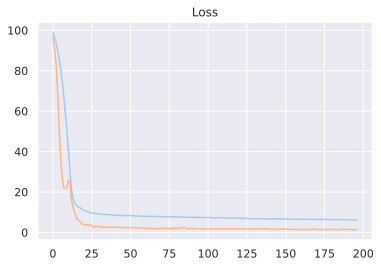

TEST mape: 1.36%


In [68]:
mlp_input = L.Input(shape = X.shape[1])
model_mlp = mlp_model(mlp_input)
model_mlp.summary()

# Compile model
optimizer = tf.keras.optimizers.Adam(0.001)
model_mlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

history = model_mlp.fit(X_train, y_train,
                    batch_size=256,
                    epochs=5000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

model_mlp.load_weights('../working/best_model.hdf5')
model_mlp.save('../working/model_mlp.hdf5')

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

test_predict_mlp = model_mlp.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_mlp[:,0]))*100:0.2f}%")

sub_predict_mlp = model_mlp.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_mlp[:,0])
sample_submission.to_csv('mlp_submission.csv', index=False)

Результат TEST mape: 1.36% хуже чем у Catboost

# Model 4: NLP + Multiple Inputs

In [22]:
# description
def clean_text(text):
    new_text = []
    #Приведение текста к нормальному виду
    text = re.sub('\n', ' ', text)
    text = re.sub('\t', ' ', text)
    text = ''.join(re.findall('[a-яА-Я\s]', text))
    #Токенизация
    for token in word_tokenize(text.lower(), language="russian"):
        #Удаление английских слов
        token = ''.join([w for w in filter(delete_english.match, token)])
        #Удаление лишних букв
        new_token = ''
        for w in token:
            #Если не цифра и знак пунктуации
            if (w not in punctuation) and (w.isdigit()==False):
                new_token += w
        token = new_token
        #Лемматизация
        token = mystem.lemmatize(token)
        if token == []:
            token = ' '
        else:
            token = token[0]
        #Стемминг
        token = snowball.stem(token)
        #Проверка стоп слово и пустое слово
        if (token not in stopwords.words("russian")) and token not in [' ','\n','\t']:
            new_text += [token]
    return ' '.join(new_text)
#Очистка
data['clean_description'] = data['description'].apply(clean_text)

In [23]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

# split данных
text_train = data.clean_description.iloc[X_train.index]
text_test = data.clean_description.iloc[X_test.index]
text_sub = data.clean_description.iloc[X_sub.index]

tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.clean_description)

print(len(tokenize.word_index))

text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

17891
(5679, 256) (1003, 256) (1671, 256)


In [24]:
# вот так теперь выглядит наш текст
print(text_train.iloc[33])
print(text_train_sequences[33])

вниман тольк клиент автомобил пробег предлага специальн кредитн программ гарант минимальн ежемесячн платеж услов кредитован первоначальн взнос размер процентн ставк посл сниженияперерасчет конец срок кред срок кред месяц год увеличива дополнительн скидк обм сво автомобил наш систем трейдин оформлен кред снижа ставк банкапартнр оформлен страхов полис скидк спецпредложен суммирова основн преимуществ автомобил установлен цезар сателл отличн техническ состоян состоян куз идеальн состоян салон автомобил стоя дешев сво ценов категор срочн продаж ти уникальн код автомобил
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

### Multiple Inputs NN: MLP + RNN NLP

In [25]:
def nlp_model(inputs):
    model = Sequential()
    model.add(inputs)
    model.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
    model.add(L.LSTM(256, return_sequences=True))
    model.add(L.Dropout(0.7))
    model.add(L.LSTM(128,))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(128, activation="elu"))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.4))
    model.add(L.Dense(64, activation="elu"))
    model.add(L.BatchNormalization())
    model.add(L.Dropout(0.3))
    return model

In [26]:
def nlp_mlp_head(combinedInput):
    head = L.Dense(128, activation="elu")(combinedInput)
    head = L.BatchNormalization()(head)
    head = L.Dropout(0.5)(head)
    head = L.Dense(64, activation="elu")(head)
    head = L.BatchNormalization()(head)
    head = L.Dropout(0.35)(head)
    return L.Dense(1, activation="linear")(head)


In [54]:
mlp_input = L.Input(shape = X.shape[1])
model_mpl = mlp_model(mlp_input)

nlp_input = L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description")
model_nlp = nlp_model(nlp_input)

combinedInput = L.concatenate([model_nlp.output, model_mpl.output])
nlp_mlp_head = nlp_mlp_head(combinedInput)

model_nlp_mlp = Model(inputs=[model_nlp.input, model_mpl.input], outputs=nlp_mlp_head)
model_nlp_mlp.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 512)          36352       input_5[0][0]                    
__________________________________________________________________________________________________
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 512)          2048        dense_20[0][0]                   
_______________________________________________________________________________________

### Fit

Epoch 1/1000
45/45 [==============================] - ETA: 0s - loss: 63.8483 - MAPE: 63.8483
Epoch 00001: saving model to ../working/best_model.hdf5
45/45 [==============================] - 6s 140ms/step - loss: 63.8483 - MAPE: 63.8483 - val_loss: 33.6960 - val_MAPE: 33.6960
Epoch 2/1000
45/45 [==============================] - ETA: 0s - loss: 15.7739 - MAPE: 15.7739
Epoch 00002: saving model to ../working/best_model.hdf5
45/45 [==============================] - 6s 127ms/step - loss: 15.7739 - MAPE: 15.7739 - val_loss: 11.1741 - val_MAPE: 11.1741
Epoch 3/1000
45/45 [==============================] - ETA: 0s - loss: 10.7719 - MAPE: 10.7719
Epoch 00003: saving model to ../working/best_model.hdf5
45/45 [==============================] - 5s 122ms/step - loss: 10.7719 - MAPE: 10.7719 - val_loss: 9.5766 - val_MAPE: 9.5766
Epoch 4/1000
45/45 [==============================] - ETA: 0s - loss: 9.3309 - MAPE: 9.3309
Epoch 00004: saving model to ../working/best_model.hdf5
45/45 [================

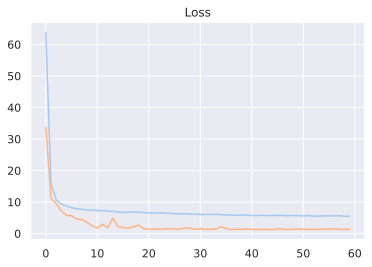

TEST mape: 1.34%


In [55]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_nlp_mlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=1, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=15, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', factor=0.5, patience=4, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

history = model_nlp_mlp.fit([text_train_sequences, X_train], y_train,
                    batch_size=128,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

model_nlp_mlp.load_weights('../working/best_model.hdf5')
model_nlp_mlp.save('../working/model_nlp_mlp.hdf5')

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

test_predict_nlp_mlp = model_nlp_mlp.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nlp_mlp[:,0]))*100:0.2f}%")

sub_predict_nlp_mlp = model_nlp_mlp.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_nlp_mlp[:,0])
sample_submission.to_csv('nlp_mlp_submission.csv', index=False)

Результат TEST mape: 1.34% лучше чем у предыдущей модели и все еще хуже чем у Catboost

# Model 5: Добавляем картинки

### Data

### Обрежем фотографии, чтобы увеличить размер автомобилей используя сеть YOLO

Код взят здесь:

http://datahacker.rs/tensorflow2-0-yolov3/

In [27]:
# Загрузим веса предобученной модели
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-09-07 09:55:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   101MB/s    in 2.3s    

2021-09-07 09:55:32 (101 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [28]:
# Импорт библиотек
import cv2
import numpy as np
import tensorflow as tf

from absl import logging
from itertools import repeat

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [29]:
# Определим несколько важных переменных, которые будем использовать ниже.

yolo_iou_threshold   = 0.8 # порог пересечения относительно объединения (iou)
yolo_score_threshold = 0.6

weightsyolov3 = 'yolov3.weights' # путь к файлу весов
weights= 'checkpoints/yolov3.tf' # путь к файлу checkpoint'ов
size= 1024             # приводим изображения к этому размеру 
checkpoints = 'checkpoints/yolov3.tf'
num_classes = 80      # количество классов в модели

#Список слоев в YOLOv3 FCN — Fully Convolutional Network
YOLO_V3_LAYERS = [
  'yolo_darknet',
  'yolo_conv_0',
  'yolo_output_0',
  'yolo_conv_1',
  'yolo_output_1',
  'yolo_conv_2',
  'yolo_output_2',
]

# функция для загрузки весов из оригинальной обученной модели YOLO в Darknet:
def load_darknet_weights(model, weights_file):
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
    layers = YOLO_V3_LAYERS

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
            if not layer.name.startswith('conv2d'):
                continue
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            logging.info("{}/{} {}".format(
                sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)

                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))

            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'не удалось прочитать все данные'
    wf.close()
    

# Функция для расчета пересечения относительно объединения
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1
    x3, x4 = interval_2
    if x3 < x1:
        return 0 if x4 < x1 else (min(x2, x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2, x4) - x3)


def intersectionOverUnion(box1, box2):
    intersect_w = interval_overlap(
        [box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = interval_overlap(
        [box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect_area = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

    union_area = w1*h1 + w2*h2 - intersect_area
    return float(intersect_area) / union_area


# Функция для отрисовки рамки, имени класса и вероятности:

def draw_outputs(img, outputs, class_names):
    boxes, score, classes, nums = outputs
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img


class BatchNormalization(tf.keras.layers.BatchNormalization):
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)
    
# Defining 3 anchor boxes for each grid

yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])


# Создание своих слоев и модели
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x


def DarknetResidual(x, filters):
    previous = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([previous, x])
    return x


def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in repeat(None, blocks):
        x = DarknetResidual(x, filters)
    return x


def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)
    x = x_36 = DarknetBlock(x, 256, 8)
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)


def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv


def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output


def yolo_boxes(pred, anchors, classes):
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, score, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, score, class_probs, pred_box

# Подавление не-максимумов
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(
            output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(
            output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(
            output[2])[0], -1, tf.shape(output[2])[-1])))

    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs

    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections

# Основная функция, создающая всю модель:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    x = inputs = Input([size, size, channels])

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                     name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

# Функция потерь:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
        (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1]
    box_wh = y_train[..., 2:4] - y_train[..., 0:2]
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                     (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1]
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1])
    iou = intersection / (box_area + anchor_area - intersection)
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2

    return tuple(outputs)  # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

# Теперь мы создаем экземпляр нашей модели, загружаем веса и имена классов. В датасете COCO их 80.
yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightsyolov3)

yolo.save_weights(checkpoints)
class_names = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
               "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
               "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
               "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
               "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
               "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
               "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
               "cake", "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
               "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
               "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

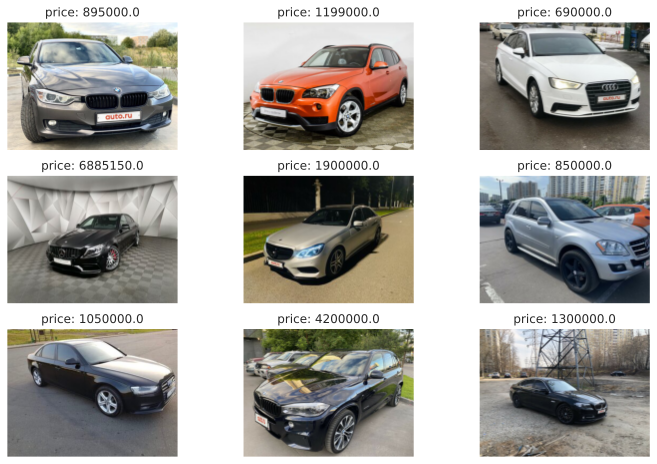

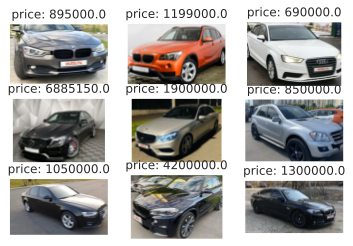

In [30]:
# Протестируем модель на каком-нибудь изображении.

# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

def crop_img(im_name):
    k = 0.1 # коэффициент для увеличения размера Bounding box
    im = PIL.Image.open(im_name)
    size = im.size
    img = tf.image.decode_image(open(im_name, 'rb').read(), channels=3)
    img = tf.expand_dims(img, 0)
    img = preprocess_image(img, max(size))
    boxes, scores, classes, nums = yolo(img) #eager mode
    x,y = size
    szx = 0
    for j in range(nums.numpy()[0]):
        if classes.numpy()[0][j] in [2,5,7]:
            xx = boxes.numpy()[0][j]
            szxj, szyj = xx[2]-xx[0], xx[3]-xx[1]
            if szxj>szx: szx, i = szxj, j
    x1,y1,x2,y2 = boxes.numpy()[0][i]  
    return im.crop((max(0,(x1-k)*x),max(0,(y1-k)*y),min(x,(x2+k)*x),min(y,(y2+k)*y)))

for index, path in enumerate(random_image_paths):
    im_name = DATA_DIR+'img/img/' + str(path) + '.jpg'
    im_crop = crop_img(im_name)            
    plt.subplot(3, 3, index + 1)
    plt.imshow(im_crop)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
    
plt.show()

In [31]:
def crop_img_cv(im_name):
    k = 0.1 # коэффициент для увеличения размера Bounding box
    image = cv2.imread(im_name)
    size = (image.shape[1], image.shape[0])
    try:
        img = tf.image.decode_image(open(im_name, 'rb').read(), channels=3)
        img = tf.expand_dims(img, 0)
        img = preprocess_image(img, max(size))
        boxes, scores, classes, nums = yolo(img) #eager mode
        x,y = size
        # выбираем самый длинный по оси Х bounding box
        szx = 0
        # Просматриваем все найденные рамки
        for j in range(nums.numpy()[0]):
            xx = boxes.numpy()[0][j]
            szxj = xx[2]-xx[0]
            if szxj>szx: szx, i = szxj, j
        x1,y1,x2,y2 = boxes.numpy()[0][i]
        # определяем размеры вырезаемой части
        x1,y1 = int(max(0,(x1-k)*x)), int(max(0,(y1-k)*y)) # левый верхний угол
        x2,y2 = int(min(x,(x2+k)*x)), int(min(y,(y2+k)*y)) # нижний правый угол
        # В OpenCV размер нового изображения задается в формате:  img(beginX:endX, beginY,endY)
        return image[x1:x2, y1:y2]
    except:
        #print('crop ', im_name)
        return cv2.imread(im_name)
    

size = (320, 240)
def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        im_name = DATA_DIR + 'img/img/' + str(sell_id) + '.jpg'
        image = crop_img_cv(im_name)           
        assert(image is not None)
        try:
            image = cv2.resize(image, size)
        except:
            print('resize ',im_name)
            image = cv2.resize(cv2.imread(im_name), size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

In [32]:
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

resize  ../input/sf-dst-car-price-prediction-part2/img/img/1098701266.jpg
images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

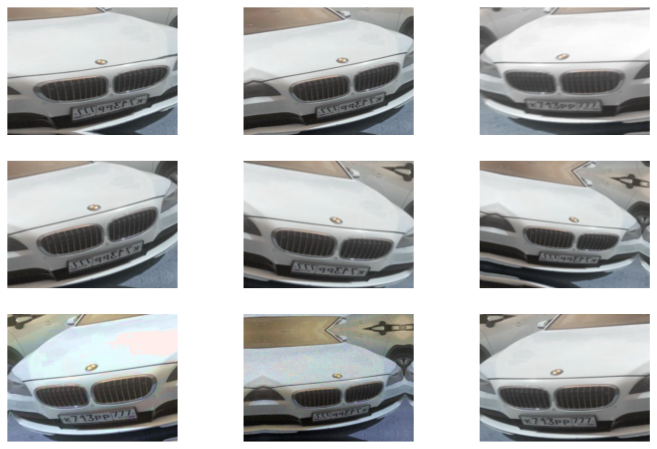

In [33]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [34]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [35]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.clean_description)

In [36]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.clean_description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.clean_description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.clean_description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

In [38]:
#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [39]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [40]:
def cv_nlp_mlp_head(combinedInput):
    head = L.Dense(64, activation="elu")(combinedInput)
    head = L.BatchNormalization()(head)
    return L.Dense(1,)(head)

In [41]:
#
mlp_input = L.Input(shape = X.shape[1])
model_mpl = mlp_model(mlp_input)

nlp_input = L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description")
model_nlp = nlp_model(nlp_input)

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, model_mpl.output, model_nlp.output])
cv_nlp_mlp_head = cv_nlp_mlp_head(combinedInput)

model_cv_nlp_mlp = Model(inputs=[efficientnet_model.input, model_mpl.input, model_nlp.input], outputs=cv_nlp_mlp_head)
model_cv_nlp_mlp.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

Epoch 1/10
178/178 [==============================] - 81s 454ms/step - loss: 21.0162 - MAPE: 21.0162 - val_loss: 32.8193 - val_MAPE: 32.8193
Epoch 2/10
178/178 [==============================] - 75s 421ms/step - loss: 3.0935 - MAPE: 3.0935 - val_loss: 10.3451 - val_MAPE: 10.3451
Epoch 3/10
178/178 [==============================] - 73s 410ms/step - loss: 2.6139 - MAPE: 2.6139 - val_loss: 4.0572 - val_MAPE: 4.0572
Epoch 4/10
178/178 [==============================] - 74s 415ms/step - loss: 2.5487 - MAPE: 2.5487 - val_loss: 2.0909 - val_MAPE: 2.0909
Epoch 5/10
178/178 [==============================] - 74s 413ms/step - loss: 2.5281 - MAPE: 2.5281 - val_loss: 2.0872 - val_MAPE: 2.0872
Epoch 6/10
178/178 [==============================] - 72s 406ms/step - loss: 2.4805 - MAPE: 2.4805 - val_loss: 2.1704 - val_MAPE: 2.1704
Epoch 7/10
178/178 [==============================] - 73s 408ms/step - loss: 2.3718 - MAPE: 2.3718 - val_loss: 2.5895 - val_MAPE: 2.5895
Epoch 8/10
178/178 [===============

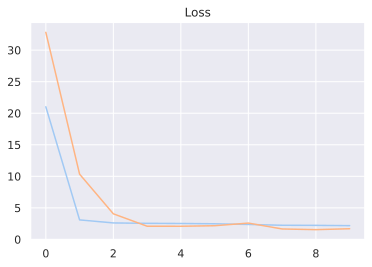

NameError: name 'model' is not defined

In [42]:
#Заморозка весов
efficientnet_model.trainable = False

optimizer = tf.keras.optimizers.Adam(0.01)
model_cv_nlp_mlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=5, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', factor=0.5, patience=2, min_lr=0.001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

history = model_cv_nlp_mlp.fit(train_dataset.batch(32),
                    epochs=10,
                    validation_data = test_dataset.batch(32),
                    callbacks=callbacks_list
                   )

model_cv_nlp_mlp.load_weights('../working/best_model.hdf5')
model_cv_nlp_mlp.save('../working/nn_final_0.hdf5')

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

test_predict_nn3 = model_cv_nlp_mlp.predict(test_dataset.batch(32))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

sub_predict_nn3 = model_cv_nlp_mlp.predict(sub_dataset.batch(32))
sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv('nn3_submission_0.csv', index=False)

TEST mape: 1.69%

Epoch 1/20
178/178 [==============================] - 81s 453ms/step - loss: 3.1913 - MAPE: 3.1913 - val_loss: 1.6565 - val_MAPE: 1.6565
Epoch 2/20
178/178 [==============================] - 78s 441ms/step - loss: 2.0772 - MAPE: 2.0772 - val_loss: 1.5082 - val_MAPE: 1.5082
Epoch 3/20
178/178 [==============================] - 77s 432ms/step - loss: 1.9760 - MAPE: 1.9760 - val_loss: 1.4968 - val_MAPE: 1.4968
Epoch 4/20
178/178 [==============================] - 81s 453ms/step - loss: 1.9233 - MAPE: 1.9233 - val_loss: 1.4857 - val_MAPE: 1.4857
Epoch 5/20
178/178 [==============================] - 77s 434ms/step - loss: 1.8752 - MAPE: 1.8752 - val_loss: 1.4927 - val_MAPE: 1.4927
Epoch 6/20
178/178 [==============================] - 78s 438ms/step - loss: 1.8074 - MAPE: 1.8074 - val_loss: 1.4622 - val_MAPE: 1.4622
Epoch 7/20
178/178 [==============================] - 77s 435ms/step - loss: 1.7812 - MAPE: 1.7812 - val_loss: 1.4122 - val_MAPE: 1.4122
Epoch 8/20
178/178 [=====================

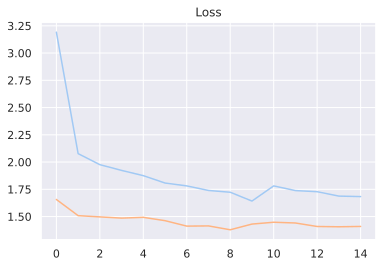

TEST mape: 1.41%


In [45]:
#Заморозка весов
efficientnet_model.trainable = True

len_lay = len(efficientnet_model.layers)
fine_tune_lay = int(len_lay * 0.6)
for layer in efficientnet_model.layers[:fine_tune_lay]:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(0.0001)
model_cv_nlp_mlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=6, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', factor=0.7, patience=2, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

history = model_cv_nlp_mlp.fit(train_dataset.batch(32),
                    epochs=20,
                    validation_data = test_dataset.batch(32),
                    callbacks=callbacks_list
                   )

model_cv_nlp_mlp.load_weights('../working/best_model.hdf5')
model_cv_nlp_mlp.save('../working/nn_final_0.hdf5')

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

test_predict_nn3 = model_cv_nlp_mlp.predict(test_dataset.batch(32))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

sub_predict_nn3 = model_cv_nlp_mlp.predict(sub_dataset.batch(32))
sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv('nn3_submission_1.csv', index=False)

TEST mape: 1.41%

Epoch 1/100
178/178 [==============================] - 127s 716ms/step - loss: 1.7385 - MAPE: 1.7385 - val_loss: 1.3864 - val_MAPE: 1.3864
Epoch 2/100
178/178 [==============================] - 124s 696ms/step - loss: 1.7061 - MAPE: 1.7061 - val_loss: 1.4015 - val_MAPE: 1.4015
Epoch 3/100
178/178 [==============================] - 124s 698ms/step - loss: 1.6562 - MAPE: 1.6562 - val_loss: 1.3934 - val_MAPE: 1.3934
Epoch 4/100
178/178 [==============================] - 123s 693ms/step - loss: 1.6204 - MAPE: 1.6204 - val_loss: 1.3902 - val_MAPE: 1.3902
Epoch 5/100
178/178 [==============================] - 124s 697ms/step - loss: 1.5976 - MAPE: 1.5976 - val_loss: 1.3870 - val_MAPE: 1.3870
Epoch 6/100
178/178 [==============================] - 124s 697ms/step - loss: 1.5472 - MAPE: 1.5472 - val_loss: 1.3763 - val_MAPE: 1.3763
Epoch 7/100
178/178 [==============================] - 125s 700ms/step - loss: 1.5335 - MAPE: 1.5335 - val_loss: 1.3583 - val_MAPE: 1.3583
Epoch 8/100
178/178 [======

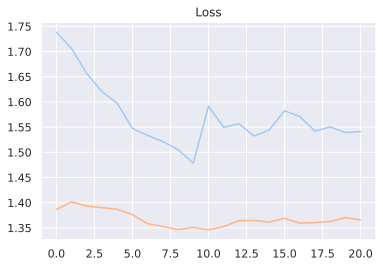

TEST mape: 1.37%


In [46]:
#Заморозка весов
efficientnet_model.trainable = True

optimizer = tf.keras.optimizers.Adam(0.00001)
model_cv_nlp_mlp.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', factor=0.7, patience=2, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

history = model_cv_nlp_mlp.fit(train_dataset.batch(32),
                    epochs=100,
                    validation_data = test_dataset.batch(32),
                    callbacks=callbacks_list
                   )

model_cv_nlp_mlp.load_weights('../working/best_model.hdf5')
model_cv_nlp_mlp.save('../working/nn_final_0.hdf5')

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

test_predict_nn3 = model_cv_nlp_mlp.predict(test_dataset.batch(32))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

sub_predict_nn3 = model_cv_nlp_mlp.predict(sub_dataset.batch(32))
sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv('nn3_submission_2.csv', index=False)

TEST mape: 1.37%

# Model Forwarding: проброс признака

new_productionDate    17.337425
enginePower           13.437133
new_model_date        13.250469
mileage               12.435549
engineDisplacement    10.222958
log_price_naive        4.524895
dtype: float64

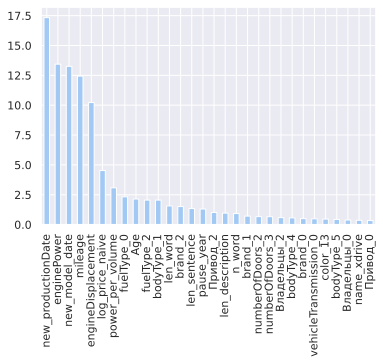

In [49]:
#Определим значимость параметров по модели CatBoostRegressor
s_sub = pd.Series(model_cat.feature_importances_,index=X_train.columns).sort_values(ascending=False)
s_sub.iloc[:30].plot(kind='bar')
#Выбор количества признаков
n = 6
#Вывод признаков
s_sub.iloc[:n]

In [75]:
model_mlp = Sequential(name='MLP')
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation='elu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.8))
model_mlp.add(L.Dense(256, activation='elu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.6))
model_mlp.add(L.Dense(128, activation='elu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.4))
model_mlp.add(L.Dense(64, activation='elu'))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dropout(0.3))

#Forwarding
model_for = Sequential(name='Forwarding')
#Первый слой
model_for.add(L.Input(shape=[n]))

#Группировка сети MLP+For
combinedInput = L.concatenate([model_mlp.output,model_for.output])
#Добавление новых слоев
#Первый слой
head = L.Dense(128, activation='elu')(combinedInput)
head = L.BatchNormalization()(head)
head = L.Dropout(0.35)(head)
#Второй слой
head = L.Dense(64, activation='elu')(head)
head = L.BatchNormalization()(head)
#Выходной
head = L.Dense(1, activation='linear')(head)
model_mlp_for = Model(inputs=[model_mlp.input,model_for.input],outputs=head,name='End')
#Информация о собранной модели
model_mlp_for.summary()

Model: "End"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_80_input (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
dense_80 (Dense)                (None, 512)          36352       dense_80_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 512)          2048        dense_80[0][0]                   
__________________________________________________________________________________________________
dropout_61 (Dropout)            (None, 512)          0           batch_normalization_136[0][0]    
________________________________________________________________________________________________

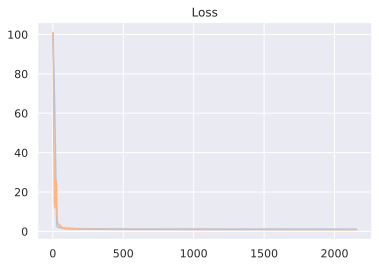

TEST mape: 0.92%


In [76]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_mlp_for.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, restore_best_weights=True,)
reduce_lr = ReduceLROnPlateau(monitor='val_MAPE', factor=0.7, patience=20, min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

#Обучение
history = model_mlp_for.fit(
    [X_train,X_train[s_sub.iloc[:n].index]],y_train,
    batch_size=512,
    epochs=10000,
    validation_data=([X_test,X_test[s_sub.iloc[:n].index]],y_test),
    callbacks=callbacks_list,
    verbose=0,
)

model_mlp_for.load_weights('../working/best_model.hdf5')
model_mlp_for.save('../working/forward.hdf5')

plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

test_predict_mlp_for = model_mlp_for.predict([X_test,X_test[s_sub.iloc[:n].index]])
print(f"TEST mape: {(mape(y_test, test_predict_mlp_for[:,0]))*100:0.2f}%")

sub_predict_mlp_for = model_mlp_for.predict([X_sub,X_sub[s_sub.iloc[:n].index]])
sample_submission['price'] = np.exp(sub_predict_mlp_for[:,0])
sample_submission.to_csv('mlp_for_submission.csv', index=False)

Проброс параметров позволил получить результат TEST mape: 0.92%, улучшив результат простой модели

# Blend

Рассмотрим два варианта: усреднение и выбор лучшего значения с помощью мета модели.

Для слияния воъмем лучшие модели: Catboost и Forwarding

In [77]:
blend_predict = (test_predict_catboost + test_predict_mlp_for[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

blend_sub_predict = (sub_predict_catboost + sub_predict_mlp_for[:,0]) / 2
sample_submission['price'] = 100*(np.exp(blend_sub_predict)//100)
sample_submission.to_csv('blend_avg_submission.csv', index=False)

TEST mape: 0.82%


Полученный результат близок к Catboost TEST mape: 0.82%

In [78]:
#Составляем DF результатов
df_sub_0 = pd.DataFrame(
    {'Y_true':y,
     'Yp_1':model_cat.predict(X),
     'Yp_2':model_mlp_for.predict([X,X[s_sub.iloc[:n].index]])[:,].flatten()
})
df_sub_1 = pd.DataFrame(
    {'Y_true':0,
     'Yp_1':model_cat.predict(X_sub),
     'Yp_2':model_mlp_for.predict([X_sub,X_sub[s_sub.iloc[:n].index]])[:,].flatten()
})
df_sub_0['sample'] = 1
df_sub_1['sample'] = 0
df_sub = pd.concat([df_sub_0,df_sub_1])

model_meta = LinearRegression(n_jobs=-1)
model_meta.fit(df_sub.query('sample==1').iloc[:,1:],df_sub.query('sample==1').iloc[:,0])
df_sub['Y_pred'] = model_meta.predict(df_sub.iloc[:,1:])

#Ошибка на обучении
print('Ошибка на обучении: {:.3f}%. На целевом признаке: {:.3f}%.'.\
      format(mape(df_sub.query('sample==1')['Y_true'],df_sub.query('sample==1')['Y_pred']),\
             mape(np.exp(df_sub.query('sample==1')['Y_true']),np.exp(df_sub.query('sample==1')['Y_pred']))))

blend2_sub_predict = df_sub.query('sample==0')['Y_pred']
sample_submission['price'] = np.exp(blend2_sub_predict)
sample_submission.to_csv('blend_lr_submission.csv', index=False)

Ошибка на обучении: 0.003%. На целевом признаке: 0.048%.


# Conclusions
1. Зафиксированы навыки работы с RNN, CNN, MLP сетями.
2. Проведен тщательный feature engineering и отобраны значимые признаки.
3. Применен механизма Transformer.
4. Выполнен blend моделей и получен сабмит с лучшим результатом на Kaggle: 12.01790

Стоит отметить, что не выполнено несколько пунктов, но точно хотелось бы выполнить:
1. Работа с выбросами числовых признаков.
2. Более тщательная проработка описания. 
3. Применение предобученных векторов и моделей обработки текста.